# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

The problem we face is that we can separate our summary statistics (=data) into subsets which are informative for different parameters, but the sizes of these subsets are not balanced. This happens frequently in practice, e.g. when one has a time series of 100 measurements, compared to a single data point. If these two statistics are informative for different parameters, then the impact of the first kind on the computed distance value can be overly high, and in addition the automatic weighting as introduced by Prangle 2017 may not reduce, or can indeed even worsen, the problem.

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative.

A toy model:

In [1]:
import pyabc
import numpy as np
import scipy as sp
import os
import tempfile
import matplotlib.pyplot as plt

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

#def model(p):
#    ss = {}
#    for j in range(N0):
#        ss['p0_' + str(j)] = p['p0'] + sp.randn()
#    for j in range(N1):
#        ss['p1_' + str(j)] = p['p1'] + 0.1 * sp.randn()
#    return ss

def model(p):
    ss = {}
    s0 = p['p0'] + 2 * sp.randn()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.01 * sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


First, we consider uniform weights of 1:

In [2]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=47, start_time=2019-09-25 10:12:29.910933, end_time=None)>
INFO:Epsilon:initial epsilon is 483.45425194465037
INFO:ABC:t:0 eps:483.45425194465037
INFO:ABC:t:1 eps:271.5597345281557
INFO:ABC:t:2 eps:126.42780661917962
INFO:ABC:t:3 eps:73.50159453265574
INFO:ABC:t:4 eps:41.83655380555141
INFO:ABC:t:5 eps:24.707594458328227
INFO:ABC:t:6 eps:15.681216865775195
INFO:ABC:t:7 eps:10.195653103016879
INFO:ABC:t:8 eps:7.533645184535245
INFO:ABC:t:9 eps:5.610589491521732
INFO:History:Done <ABCSMC(id=47, start_time=2019-09-25 10:12:29.910933, end_time=2019-09-25 10:13:41.423829)>


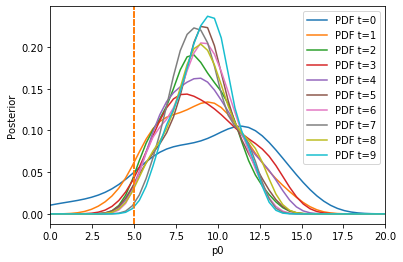

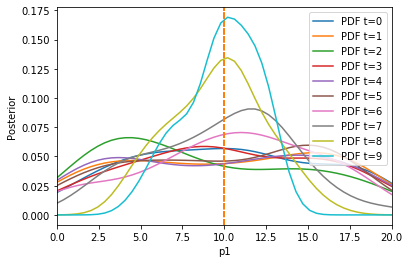

In [3]:
# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

Next, we use adaptive distances but no factors:

INFO:History:Start <ABCSMC(id=48, start_time=2019-09-25 10:13:42.537575, end_time=None)>
INFO:Epsilon:initial epsilon is 475.4889689993775
INFO:ABC:t:0 eps:475.4889689993775
INFO:ABC:t:1 eps:236.5028268856349
INFO:ABC:t:2 eps:124.72158458233216
INFO:ABC:t:3 eps:67.7664483591792
INFO:ABC:t:4 eps:35.58660925534456
INFO:ABC:t:5 eps:19.772739263215623
INFO:ABC:t:6 eps:12.640793531727969
INFO:ABC:t:7 eps:7.938654505701834
INFO:ABC:t:8 eps:5.353556112784082
INFO:ABC:t:9 eps:3.770024950297865
INFO:History:Done <ABCSMC(id=48, start_time=2019-09-25 10:13:42.537575, end_time=2019-09-25 10:15:15.118232)>


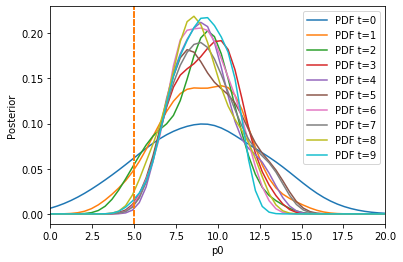

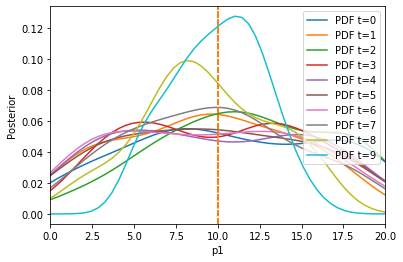

In [4]:
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=10)

plot(history2)

Next, we account for the discrepancy in data point coutns by using factors:

INFO:History:Start <ABCSMC(id=49, start_time=2019-09-25 10:15:16.260099, end_time=None)>
INFO:Epsilon:initial epsilon is 10.329460274379288
INFO:ABC:t:0 eps:10.329460274379288
INFO:ABC:t:1 eps:6.700853961105321
INFO:ABC:t:2 eps:4.547452888018626
INFO:ABC:t:3 eps:3.200276507759509
INFO:ABC:t:4 eps:2.14026627277077
INFO:ABC:t:5 eps:1.4846131065566188
INFO:ABC:t:6 eps:1.0502584420186944
INFO:ABC:t:7 eps:0.6747740322353251
INFO:ABC:t:8 eps:0.48720232955761617
INFO:ABC:t:9 eps:0.33624923546576224
INFO:History:Done <ABCSMC(id=49, start_time=2019-09-25 10:15:16.260099, end_time=2019-09-25 10:15:57.727369)>


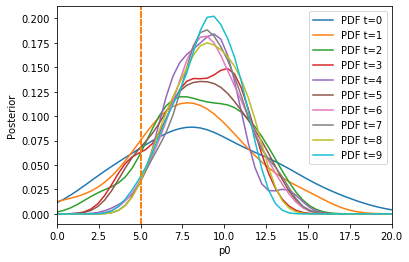

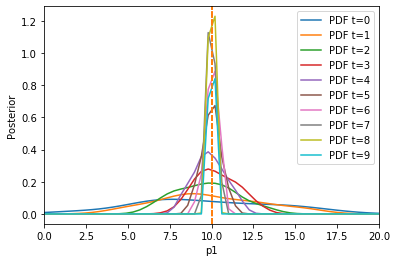

In [5]:
factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=10)

plot(history3)

Next, we consider automatic weighting and factors:

INFO:History:Start <ABCSMC(id=50, start_time=2019-09-25 10:15:58.842585, end_time=None)>
INFO:Epsilon:initial epsilon is 10.61209227801203
INFO:ABC:t:0 eps:10.61209227801203
INFO:ABC:t:1 eps:7.686286917677466
INFO:ABC:t:2 eps:5.455466053567605
INFO:ABC:t:3 eps:3.976056652008659
INFO:ABC:t:4 eps:3.0949370607635136
INFO:ABC:t:5 eps:2.6284574172917288
INFO:ABC:t:6 eps:2.418968502773528
INFO:ABC:t:7 eps:1.8630003467618563
INFO:ABC:t:8 eps:1.7518892929110907
INFO:ABC:t:9 eps:1.505220524854698
INFO:History:Done <ABCSMC(id=50, start_time=2019-09-25 10:15:58.842585, end_time=2019-09-25 10:16:35.738054)>


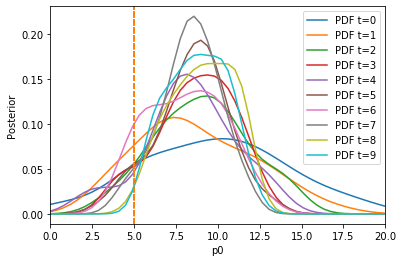

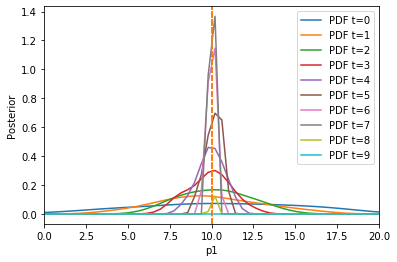

In [6]:
import logging
df_logger = logging.getLogger('Distance')
# df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=10)

plot(history4)

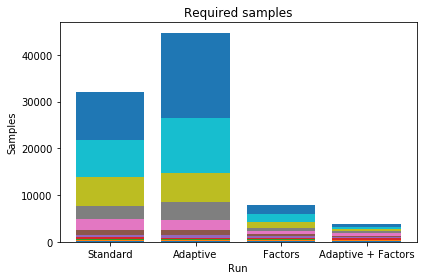

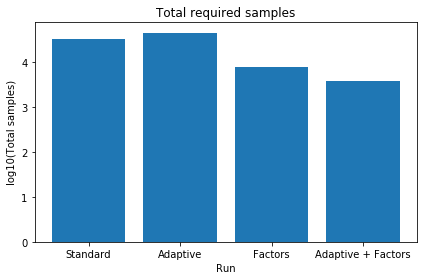

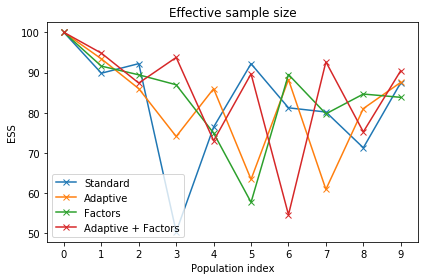

In [7]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Factors", "Adaptive + Factors"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10')
pyabc.visualization.plot_effective_sample_sizes(histories, labels)

## Aggregating diverse distance functions

Now, we want to combine different distance metrics operating on subsets of the data to one distance value. We consider a slightly advanced model, combining a conversion reaction ODE model with samples from a normal distribution.

In [8]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

# true parameters
theta1_true, theta2_true = sp.exp([-2.5, -2])
theta_true = dict(theta1=theta1_true, theta2=theta2_true)

In [9]:
# conversion reaction (cr) model

measurement_data = sp.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])
measurement_times = sp.arange(len(measurement_data))      
init = sp.array([1, 0])


def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2


def cr_model(p):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(p["theta1"], p["theta2"]))
    return {"X_2": sol[:,1]}


def cr_l1_distance(simulation, data):
    return sp.absolute(data["X_2"] - simulation["X_2"]).sum()

In [10]:
# normal distribution samples


def gauss_model(p):
    samples = p['theta1'] + np.random.normal(size=100)
    return {'samples': samples}


def gauss_ks_distance(simulation, data):
    return stats.ks_2samp(simulation['samples'], data['samples']).statistic

observed_samples = gauss_model(theta_true)['samples']
# observation
observation = {'X_2': measurement_data,
               'samples': observed_samples}

The key is now to use `pyabc.distance.AggregatedDistance` to combine both.

In [11]:
def model(p):
    cr_ss = cr_model(p)
    gauss_ss = gauss_model(p)
    return {'X_2': cr_ss['X_2'], 'samples': gauss_model(p)['samples']}


distance = pyabc.distance.base.AggregatedDistance(
    distances=[cr_l1_distance, gauss_ks_distance], weights=[1, 10])
                           
# prior                           
parameter_prior = pyabc.Distribution(theta1=pyabc.RV("uniform", 0, 1),
                                     theta2=pyabc.RV("uniform", 0, 1))


abc = pyabc.ABCSMC(models=model,
                   parameter_priors=parameter_prior,
                   distance_function=distance,)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:History:Start <ABCSMC(id=51, start_time=2019-09-25 10:16:38.639466, end_time=None)>
INFO:Epsilon:initial epsilon is 5.678159728824011
INFO:ABC:t:0 eps:5.678159728824011
INFO:ABC:t:1 eps:3.344268214375947
INFO:ABC:t:2 eps:2.61459770088934
INFO:ABC:t:3 eps:2.1893771617308286
INFO:ABC:t:4 eps:1.9177939624710512
INFO:History:Done <ABCSMC(id=51, start_time=2019-09-25 10:16:38.639466, end_time=2019-09-25 10:16:42.258884)>


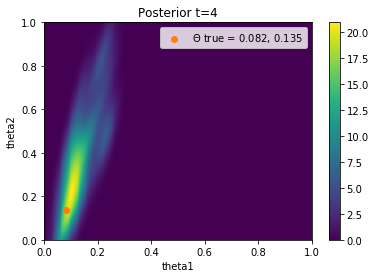

In [12]:
for t in range(h.max_t, h.max_t+1):
    ax = pyabc.visualization.plot_kde_2d(*h.get_distribution(m=0, t=t),
                                         "theta1", "theta2",
                xmin=0, xmax=1, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.scatter([theta1_true], [theta2_true],
                color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    theta1_true, theta2_true))
    ax.set_title("Posterior t={}".format(t))
    ax.legend()

In [13]:
for _ in range(10):
    p = dict(parameter_prior.rvs())
    sim = model(p)
    print(p, cr_l1_distance(sim, observation), gauss_ks_distance(sim, observation))
print(theta_true, gauss_ks_distance(observation, observation))

{'theta1': 0.404736123504162, 'theta2': 0.5963896161072035} 1.41855702525856 0.22999999999999998
{'theta1': 0.2106987175206858, 'theta2': 0.8213417952388337} 0.7639921158235012 0.15999999999999998
{'theta1': 0.6077461786713314, 'theta2': 0.9291116835349764} 1.4567293079253767 0.26
{'theta1': 0.47205137499184213, 'theta2': 0.5216022604756362} 2.0820042104040763 0.23000000000000004
{'theta1': 0.22864904390493934, 'theta2': 0.6997793269892524} 0.5747737159743181 0.12
{'theta1': 0.37453674449415053, 'theta2': 0.8443250960427874} 0.6132090044685401 0.21999999999999997
{'theta1': 0.7886266544502826, 'theta2': 0.3195998239171325} 4.375996487779142 0.43999999999999995
{'theta1': 0.5410262393938882, 'theta2': 0.027940556908420122} 5.883059279719294 0.29000000000000004
{'theta1': 0.492815069728604, 'theta2': 0.9094065593901036} 1.0104348309901812 0.22000000000000003
{'theta1': 0.33975802757856277, 'theta2': 0.4553543033377214} 1.5320222223923754 0.24
{'theta1': 0.0820849986238988, 'theta2': 0.13